In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
%run 02_Pandas_missing_extension.ipynb

/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


### Plots configurations

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula='temp ~ ozone ',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 19 Apr 2023",Prob (F-statistic):,2.93e-18
Time:,12:47:46,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r ',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 19 Apr 2023",Prob (F-statistic):,1.47e-16
Time:,12:47:46,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


In [7]:
survival_df = sm.datasets.get_rdataset('flchain','survival').data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


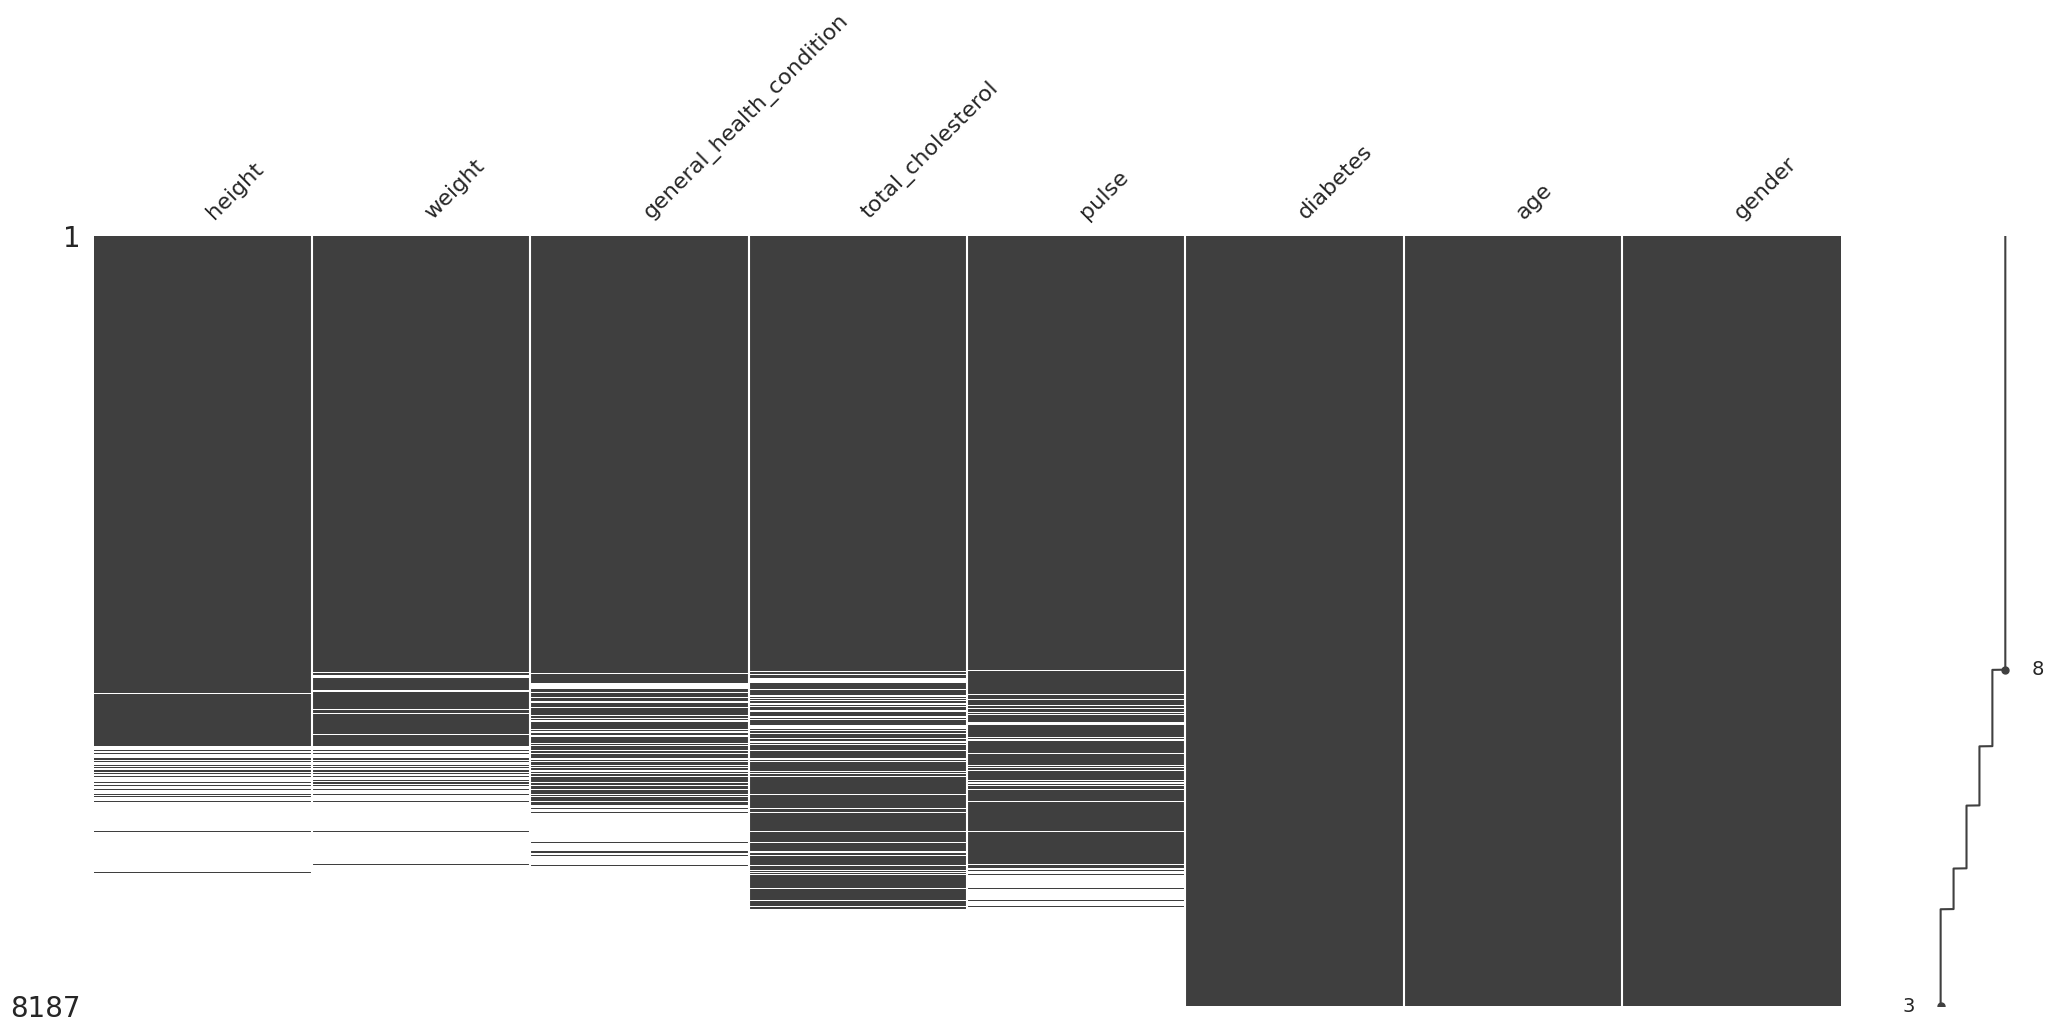

/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


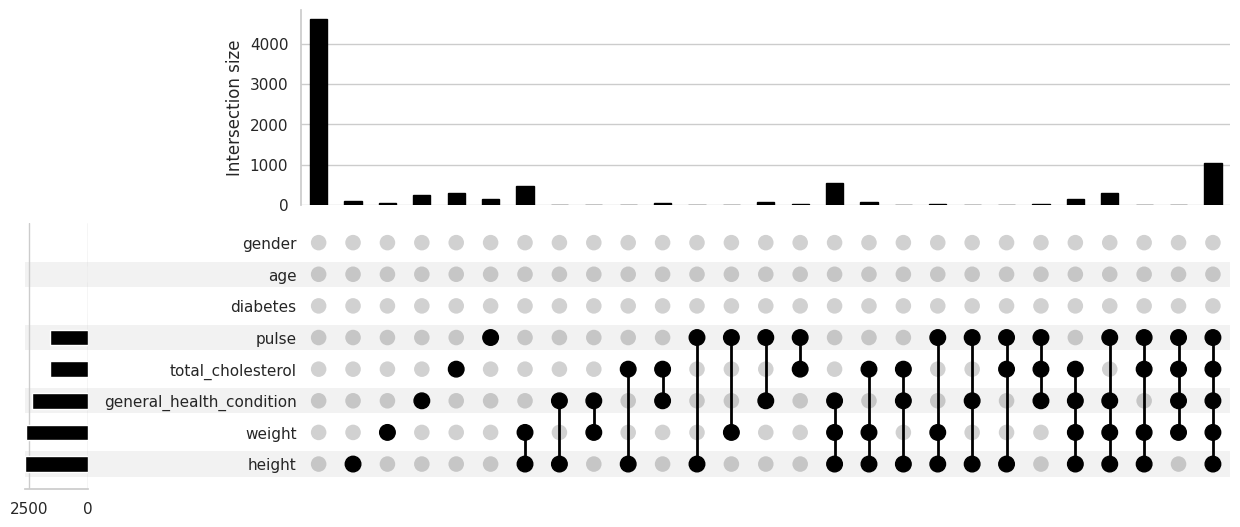

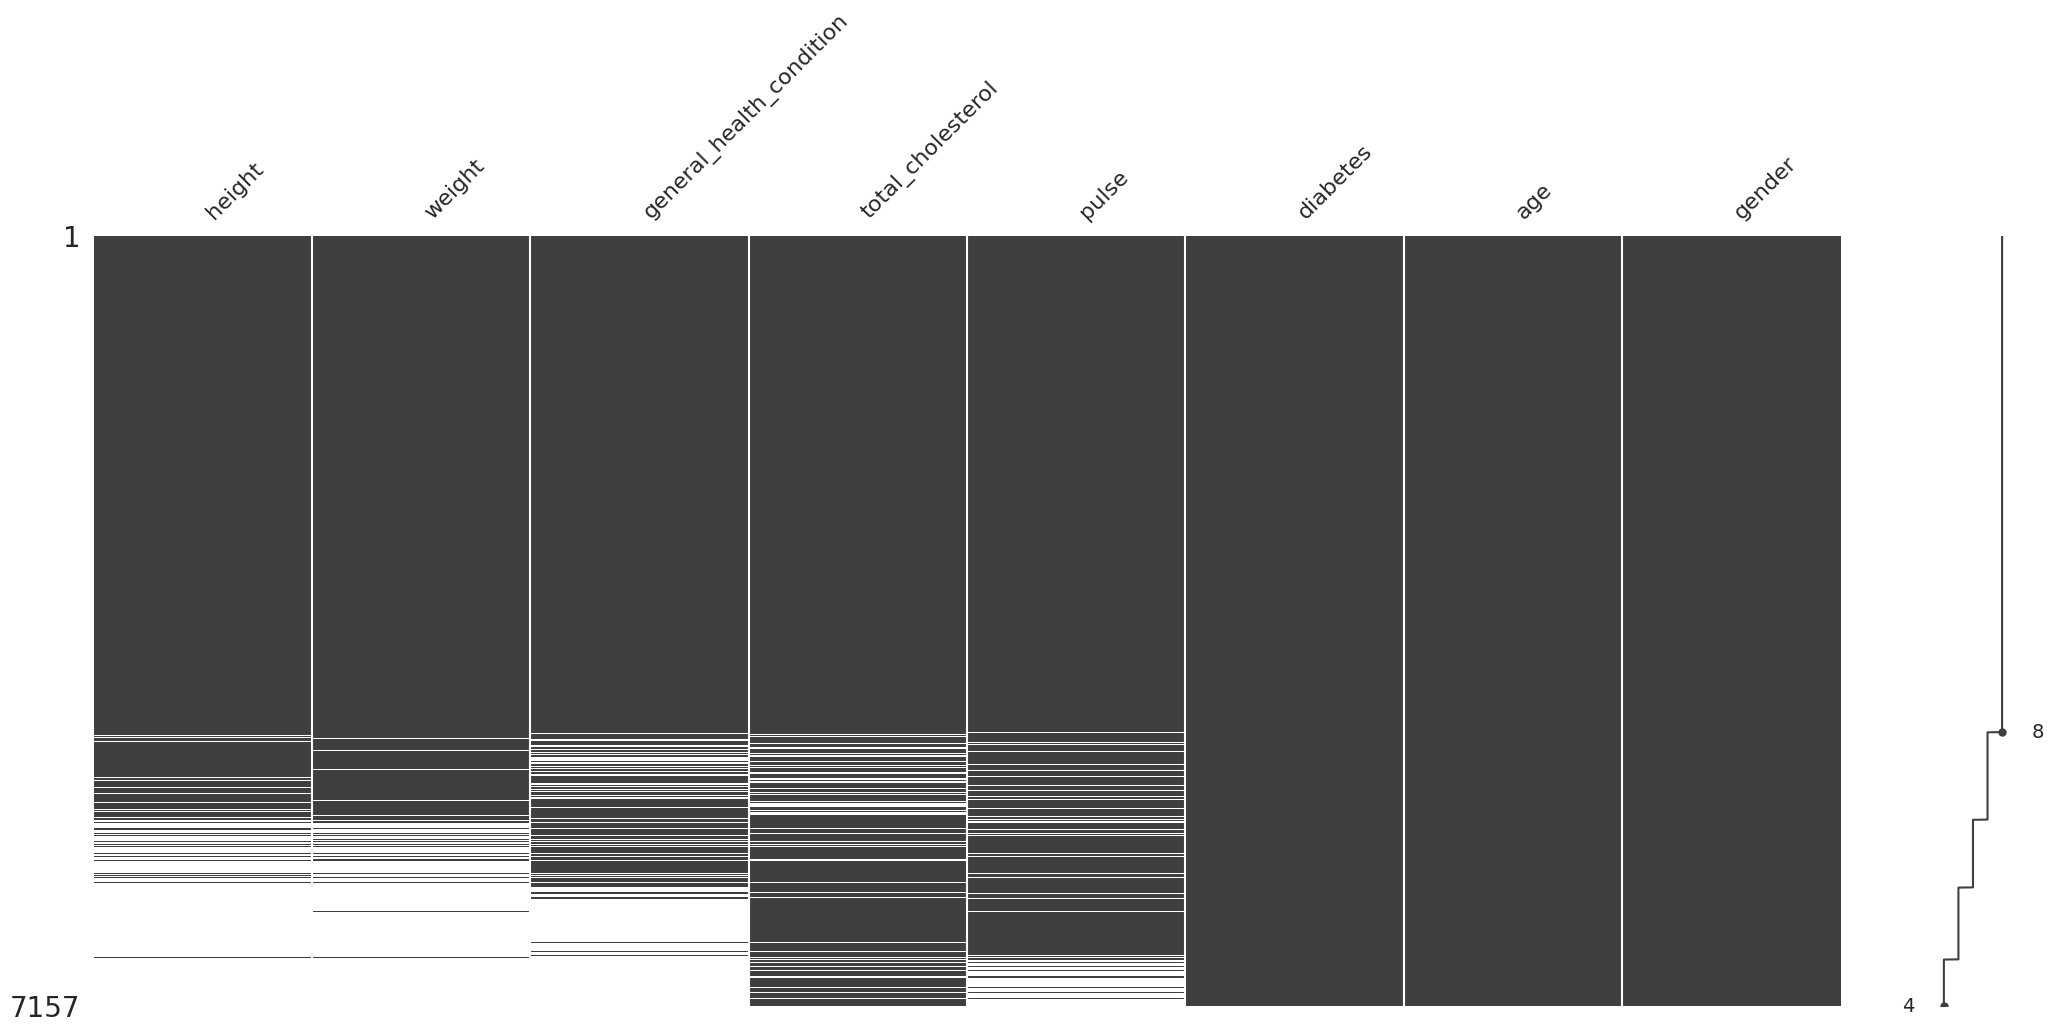

In [8]:
%run 03_Download_data_and_load_it.ipynb

### t-test

In [9]:
female_weight, male_weight = (
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x:x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

### Missign values

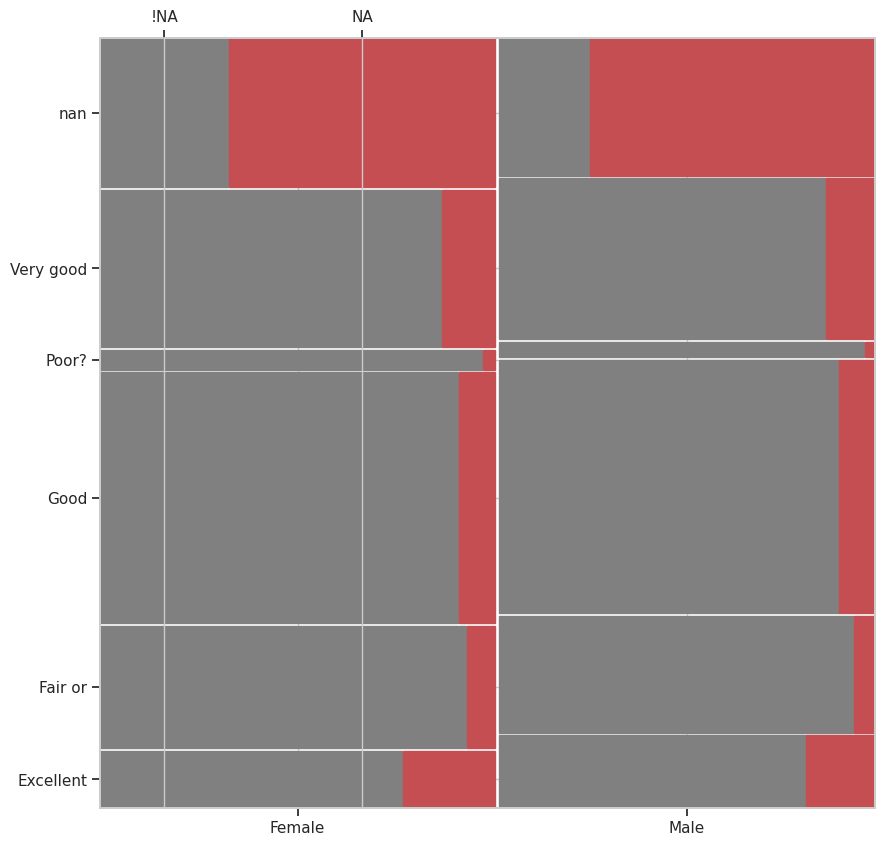

In [14]:
fig,ax = plt.subplots(figsize = (10,10))

(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True,False],['NA', '!NA'])
    )
    .groupby(
        ["gender", "general_health_condition", "weight"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data= df,
            properties= lambda key : {"color": "r" if "NA" in key else "gray"},
            horizontal= True,
            axes_label=True,
            title='',
            labelizer=lambda key: '',
            ax = ax
        )
    )
);